

## We will examine two ways to use a classifier predict near failure samples

1. Ignoring time constrains (i.e. use data as one set and build train and testing set using shufling)
2. Selecting train and test data depending on the actual time of the episodes. (i.e. first observed episodes will be used for training and later observed episodes for testing, as it will be done in real world scenario).

#### Load data

Load episode data of the same Module.

Epiosdes 2,3,7,11 and 12 are end with failure, while episodes 18 and 20 ending with no failure.

In [4]:
import pandas as pd
isfailure=[]
dflist=[]
for episode in [2,3,7,11,12,18,20]:#range(1,21):
    if episode<13:
        isfailure.append(1)
    else:
        isfailure.append(0)
    
    df=pd.read_csv(f"CaseStudyData/Episode{episode}.csv",index_col=0)
    #df = df.sub(df.min(axis=1), axis=0).div(df.max(axis=1) - df.min(axis=1), axis=0)

    dflist.append(df)

Utilizing a predictive horizon (a time period in the end of the failure episodes) we can characterize each instance as positive **1** (if it belongs in the Predictive Horizon) or negative **0** (anywhere else).

Finally gather all data together.

In [5]:
def makedlabels(df,PH=210,isfail=True):
    if isfail:
        labels=[0 if len(df.index)-i>PH else 1 for i in range(len(df.index))]
        return labels
    else:
        return [0 for i in range(len(df.index))]
def makedatase(dflist,isfailure,PH=210):
    X=dflist[0].values
    y=makedlabels(dflist[0],PH,isfailure[0])
    for df,isfail in zip(dflist[1:],isfailure[1:]):
        labels=makedlabels(df,PH,isfail)
        X=np.append(X, df.values,axis=0)
        y.extend(labels)
    return X,y

In [6]:
import numpy as np
X,y=makedatase(dflist,isfailure,PH=210)

Split data to Testing and Training test using shuffling (50% train,50% test) and fit an xgboost classifier on training data. 

Finally calculate the f1 score using the testing data.

In [8]:
from  sklearn.model_selection import train_test_split
import sklearn.metrics
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.5)
clf = XGBClassifier()
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
print("f1 score: ", sklearn.metrics.f1_score(y_test, y_pred))

f1 score:  0.8164948453608248


Evaluation using our PdM Kpis (f2 score). In both training and testing episodes.

In [10]:
allingoreindexes=[]
ignoredf=pd.read_csv(f"CaseStudyData/ignoreindexes.csv",index_col=0)
for start,end in zip(ignoredf['start'],ignoredf['end']):
    allingoreindexes.append((start,end))

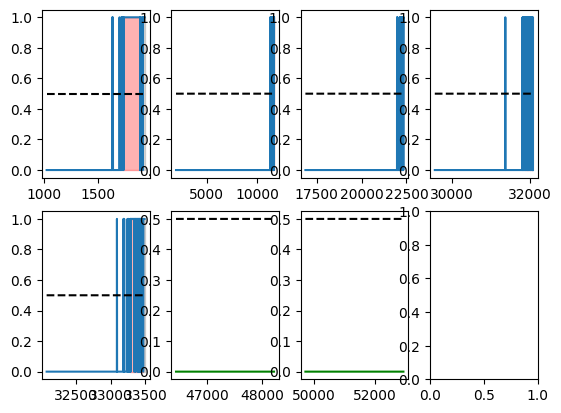

F2: AD1 0.9889025893958077,AD2 0.8857963331124368,AD3 0.7943113951879778
Recall: AD1 1.0,AD2 0.8717391304347828,AD3 0.7635553824145509
Precission: 0.9468713105076741


In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import evaluation
predictions=[]
thresholds=[]
isfailure=[]
indexes=[]
for episode in [2,3,7,11,12,18,20]:
    if episode<13:
        isfailure.append(1)
    else:
        isfailure.append(0)
    # horizontal normalization
    episodedf=pd.read_csv(f"CaseStudyData/Episode{episode}.csv",index_col=0)

    anomalyscores,threshold= clf.predict(episodedf.values),0.5
    predictions.append(list(anomalyscores))
    thresholds.append(threshold)
    indexes.append(list(episodedf.index[-len(anomalyscores):]))


recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,datesofscores=indexes,PH="210",lead="26",beta=2,isfailure=isfailure,ignoredates=allingoreindexes)
plt.show()
print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")

As we can see the results are quite good.

### Now lets perform the same experiment with respecting the time order of episodes collection.

In [12]:
m2a=dflist
isfailm2a=isfailure

############# BUILDING TRAIN DATASET #####################################
Xm2atrain=m2a[0].values
labelstrain=[0 if len(m2a[0])-i>210 else 1 for i in range(len(m2a[0]))]

Xm2atrain=np.append(Xm2atrain,m2a[1].values,axis=0)
labelstrain.extend([0 if len(m2a[1])-i>210 else 1 for i in range(len(m2a[1]))])

Xm2atrain=np.append(Xm2atrain,m2a[2].values,axis=0)
labelstrain.extend([0 if len(m2a[2])-i>210 else 1 for i in range(len(m2a[2]))])

Xm2atrain=np.append(Xm2atrain,m2a[5].values,axis=0)
labelstrain.extend([0 for i in range(len(m2a[5]))])


############# BUILDING TEST DATASET #####################################

Xm2test=m2a[3].values
labelstest=[0 if len(m2a[3]) -i >210 else 1 for i in range(len(m2a[3]))]

Xm2test=np.append(Xm2test,m2a[4].values,axis=0)
labelstest.extend([0 if len(m2a[4])-i>210 else 1 for i in range(len(m2a[4]))])

Xm2test=np.append(Xm2test,m2a[6].values,axis=0)
labelstest.extend([0 for i in range(len(m2a[6]))])

print(len(Xm2test))
print(len(labelstest))
print(len(Xm2atrain))
print(len(labelstrain))

7124
7124
17910
17910


Train and Test xgboost classifier.

In [14]:
clf2 = XGBClassifier()
clf2.fit(Xm2atrain, labelstrain)

y_pred = clf2.predict(Xm2test)
print("f1 score: ", sklearn.metrics.f1_score(labelstest, y_pred))

f1 score:  0.019476905954368393


Results show big difference with the first methodology. **f1 score=0.2**

Using all episodes with our evaluation (f2 score): As its seems classifier could perform only in training data and not in new ones.

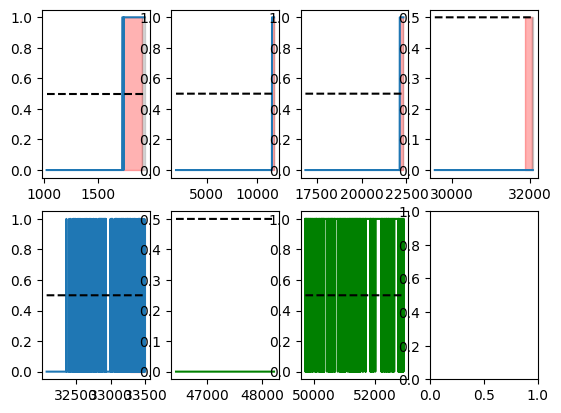

F2: AD1 0.4384905660377359,AD2 0.3925675675675676,AD3 0.30576435439625566
Recall: AD1 0.8,AD2 0.6315217391304347,AD3 0.40202184131201146
Precission: 0.15618279569892474


In [16]:
predictions=[]
thresholds=[]
isfailure=[]
indexes=[]
for episode in [2,3,7,11,12,18,20]:
    if episode<13:
        isfailure.append(1)
    else:
        isfailure.append(0)
    # horizontal normalization
    episodedf=pd.read_csv(f"CaseStudyData/Episode{episode}.csv",index_col=0)

    anomalyscores,threshold= clf2.predict(episodedf.values),0.5
    predictions.append(list(anomalyscores))
    thresholds.append(threshold)
    indexes.append(list(episodedf.index[-len(anomalyscores):]))


recall,Precision,fbeta,axes=evaluation.myeval(predictions,thresholds,datesofscores=indexes,PH="210",lead="26",beta=2,isfailure=isfailure,ignoredates=allingoreindexes)
plt.show()
print(f"F2: AD1 {fbeta[0]},AD2 {fbeta[1]},AD3 {fbeta[2]}")
print(f"Recall: AD1 {recall[0]},AD2 {recall[1]},AD3 {recall[2]}")
print(f"Precission: {Precision}")